In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import cvxpy as cp

from decentr_qp import *
import ciropt as co

### Set the parameters for problem setup and generate random matrices and vectors

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_node'] = 20
problem_spec['vector_size'] = 50
print(problem_spec)

problem_data = data_generation(problem_spec)
network_data = graph_generation(problem_spec['n_node'])
problem_data['itr_num'] = 1000

{'n_node': 20, 'vector_size': 50}


### Check the solution is different from unconstrained problem

In [3]:
f_star, x_opt_star = min_cvx_quad_constraint(problem_spec, problem_data, True)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

unconstrained_f_star, unconstrained_x_opt_star = min_cvx_quad_constraint(problem_spec, problem_data, False)
if (f_star, x_opt_star) == (unconstrained_f_star, unconstrained_x_opt_star):
    print("Constraints have no meaning")
else:
    print("Constraints have meaning")

f_star=2.1948467594377186, np.linalg.norm(x_opt_star)=0.3135937994184583
Constraints have meaning


### Draw the network graph

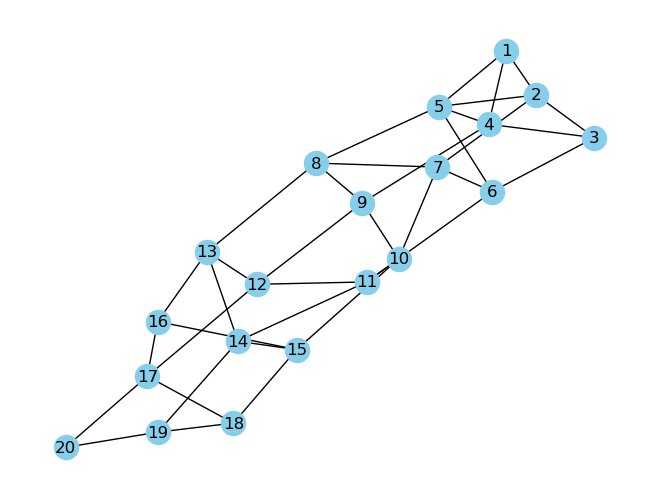

In [4]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True)
plt.savefig("plots/graph_n20.pdf")

### Define functions and proximal operators to implement the method

In [5]:
Q = problem_data['Q']
p = problem_data['p']
a = problem_data['a']
b = problem_data['b']
n_node = problem_spec['n_node']
vector_size = problem_spec['vector_size']

prox_operators = []
grad_h = []
f_plus_h = []

for jj in range(n_node):
    Qj, pj, aj, bj = Q[jj], p[jj], a[jj], b[jj]
    prox_operators += [lambda z, rho, aj=aj, bj=bj : prox_fj_quad_constraint(z, rho, aj, bj) ]
    grad_h += [lambda z, Qj=Qj, pj=pj : grad_hj_quad_constraint(z, Qj, pj) ]
    f_plus_h += [lambda x_kj, Qj=Qj, pj=pj : 1/2 * x_kj @ Qj @ x_kj.T + np.dot(pj, x_kj) ]

### Find parameters for PG-EXTRA with grid search

In [6]:
def pg_optimization_func(param):
    problem_data['rho'] = param
    problem_data['itr_num'] = 400
    pg_f_reldiff = co.pg_extra("pg_extra", problem_spec, problem_data, network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                    grad_h=grad_h, f_plus_h=f_plus_h,
                                                                    printing=False)[-1]
    return pg_f_reldiff

best_rho = round(co.grid_search(pg_optimization_func, np.arange(0.01, 0.1, 0.005), start=300, end=400), 2)
print("best_rho :", best_rho)
problem_data['itr_num'] = 1000

new param=0.01, new new_val=6.397972770441469e-05
new param=0.015, new new_val=1.319213630457193e-05
new param=0.019999999999999997, new new_val=1.775525879346698e-06
new param=0.024999999999999998, new new_val=2.202945053081765e-07
new param=0.03, new new_val=1.6543004644945507e-08
new param=0.034999999999999996, new new_val=2.0423295614907362e-09
new param=0.039999999999999994, new new_val=3.991474814858268e-10
new param=0.045, new new_val=1.2425445256248354e-10
new param=0.049999999999999996, new new_val=3.765508755843756e-11
new param=0.05499999999999999, new new_val=1.4781512508700383e-11
best_param = 0.05499999999999999
best_rho : 0.05


#### Run PG-EXRA with the best working parameter

In [7]:
problem_data['rho'] = best_rho

pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = co.pg_extra("pg_extra", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        grad_h=grad_h, f_plus_h=f_plus_h,
                                                                        printing=True, freq=200)

ii=0, f_reldiff[-1]=0.9002983179989965, err_opt_reldiff[-1]=0.8956452780077516
ii=200, f_reldiff[-1]=1.572662984745637e-07, err_opt_reldiff[-1]=6.188406466278637e-07
ii=400, f_reldiff[-1]=7.417515761908602e-13, err_opt_reldiff[-1]=3.876877184110101e-12
ii=600, f_reldiff[-1]=6.069980165227989e-16, err_opt_reldiff[-1]=4.177078211201916e-15
ii=800, f_reldiff[-1]=4.0466534434853256e-16, err_opt_reldiff[-1]=4.414497706441644e-15
ii=999, f_reldiff[-1]=2.0233267217426628e-16, err_opt_reldiff[-1]=4.615703812139067e-15


### Run PG-EXTRA + Parallel C

In [8]:
params={"R":0.07, "Capacitance":0.3, "h":0.8}  

pg_c_op_norm, pg_c_err_opt_star, pg_c_err_opt_reldiff, pg_c_const_vio, pg_c_f_reldiff = co.pg_extra("pg_extra_par_c", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        grad_h=grad_h, f_plus_h=f_plus_h,
                                                                        params=params, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.917028633176678, err_opt_reldiff[-1]=0.8959053207128286
ii=200, f_reldiff[-1]=2.959942466512493e-09, err_opt_reldiff[-1]=3.345561218200481e-08
ii=400, f_reldiff[-1]=2.0233267217426628e-16, err_opt_reldiff[-1]=1.6945607570599656e-15
ii=600, f_reldiff[-1]=4.0466534434853256e-16, err_opt_reldiff[-1]=9.414066242586708e-16
ii=800, f_reldiff[-1]=4.0466534434853256e-16, err_opt_reldiff[-1]=9.450756711082992e-16
ii=999, f_reldiff[-1]=4.0466534434853256e-16, err_opt_reldiff[-1]=9.31247799160273e-16


##### Running PG-EXTRA with same step size with PG-EXTRA + Parallel C

In [9]:
problem_data['rho'] = 0.07

pg_worse_op_norm, pg_worse_err_opt_star, pg_worse_err_opt_reldiff, pg_worse_const_vio, pg_worse_f_reldiff = co.pg_extra("pg_extra", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        grad_h=grad_h, f_plus_h=f_plus_h,
                                                                        printing=True, freq=200)

ii=0, f_reldiff[-1]=0.917028633176678, err_opt_reldiff[-1]=0.8959053207128286
ii=200, f_reldiff[-1]=9.99242876832438e-06, err_opt_reldiff[-1]=8.510545095692667e-05
ii=400, f_reldiff[-1]=7.531367142545028e-09, err_opt_reldiff[-1]=6.414600401554746e-08
ii=600, f_reldiff[-1]=5.677050115865563e-12, err_opt_reldiff[-1]=4.834867356261134e-11
ii=800, f_reldiff[-1]=4.6536514600081244e-15, err_opt_reldiff[-1]=3.682625880248678e-14
ii=999, f_reldiff[-1]=4.0466534434853256e-16, err_opt_reldiff[-1]=5.416931041417606e-15


## Plot the results

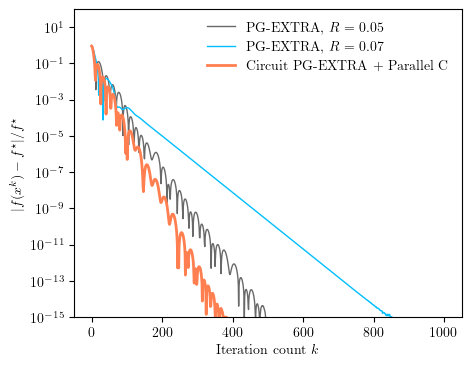

In [10]:
fname = "n20_circuit_pg_extra_par_c"

T = 1000
co.plot_methods([pg_f_reldiff[:T] ,pg_worse_f_reldiff[:T], pg_c_f_reldiff[:T]],
                ['PG-EXTRA, $R=0.05$', 'PG-EXTRA, $R=0.07$', 'Circuit PG-EXTRA + Parallel C'], 1e-15, 1e+2, fname)

#### Check the first iteration where the error falls below a certain criterion for each method

In [11]:
criterion = 1e-8

print( np.where(np.array(pg_c_f_reldiff) < criterion)[0][0] )
print( np.where(np.array(pg_f_reldiff) < criterion)[0][0] )
print( np.where(np.array(pg_worse_f_reldiff) < criterion)[0][0] )

147
214
393
